# IMDb Linear Regression Analysis w/o Placeholder

In [1]:
import pandas as pd
import numpy as np

import psycopg2
from sqlalchemy import create_engine
from config import db_password

import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import time

%matplotlib inline
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV, Ridge, RidgeCV

In [2]:
# Loading data
file = ('Movies.csv')
movies_df = pd.read_csv(file)
updated_imdb = pd.read_csv('updated_imdb.csv')

In [3]:
movies_df = movies_df.drop(columns=['Unnamed: 0', 'ID', 'Type', 'Rotten Tomatoes'])

In [4]:
movies_null_IMDb = movies_df[movies_df['IMDb'].isnull()]

In [5]:
updated_titles = updated_imdb['Title'].tolist()
movies_df = movies_df[~movies_df['Title'].isin(updated_titles)]
movies_df = movies_df.append(updated_imdb)
movies_df['IMDb'] = movies_df['IMDb'].fillna(0)

In [6]:
text_cols = ['Directors', 'Genres', 'Country', 'Language']

for col in text_cols:
    movies_df[col] = movies_df[col].astype('str')
    

In [7]:
movies_df

,Title,Year,Age,IMDb,Netflix,Hulu,Prime Video,Disney+,Directors,Genres,Country,Language,Runtime
0,Inception,2010.0,13+,8.8,1,0,0,0,Christopher Nolan,"Action,Adventure,Sci-Fi,Thriller","United States,United Kingdom","English,Japanese,French",148.0
1,The Matrix,1999.0,18+,8.7,1,0,0,0,"Lana Wachowski,Lilly Wachowski","Action,Sci-Fi",United States,English,136.0
2,Avengers: Infinity War,2018.0,13+,8.5,1,0,0,0,"Anthony Russo,Joe Russo","Action,Adventure,Sci-Fi",United States,English,149.0
3,Back to the Future,1985.0,7+,8.5,1,0,0,0,Robert Zemeckis,"Adventure,Comedy,Sci-Fi",United States,English,116.0
4,"The Good, the Bad and the Ugly",1966.0,18+,8.8,1,0,1,0,Sergio Leone,Western,"Italy,Spain,West Germany",Italian,161.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
44,The Iranian Americans,NaN,NaN,5.3,0,0,1,0,nan,Documentary,nan,nan,NaN
45,Wrestling with Satan,NaN,NaN,5.4,0,0,1,0,"Paul Aldridge, Tom Borden",Documentary,America,nan,85.0
46,Passing Through,NaN,NaN,8.4,0,0,0,0,nan,Documentary,nan,nan,66.0
47,Murder Gardens,NaN,NaN,7.2,0,0,0,0,Mark A. Samuels,"Drama, Action & Adventure",nan,nan,141.0


In [8]:
movies_df.count()

Title          16744
Year           16695
Age             7357
IMDb           16744
Netflix        16744
Hulu           16744
Prime Video    16744
Disney+        16744
Directors      16744
Genres         16744
Country        16744
Language       16744
Runtime        16159
dtype: int64

In [9]:
movies_df.loc[movies_df['IMDb'] >= 7, 'Rating Category'] = '7+'
movies_df.loc[movies_df['IMDb'] < 7, 'Rating Category'] = 'Below 7'

movies_df['Rating Category'].value_counts()

Below 7    12931
7+          3813
Name: Rating Category, dtype: int64

In [10]:
le = LabelEncoder()
df2 = movies_df.copy()
df2 = pd.get_dummies(df2, columns=['Age'])
df2['Directors'] = le.fit_transform(df2['Directors'].astype(str))
df2['Genres'] = le.fit_transform(df2['Genres'].astype(str))
df2['Country'] = le.fit_transform(df2['Country'].astype(str))
df2['Language'] = le.fit_transform(df2['Language'].astype(str))
df2['Rating Category'] = le.fit_transform(df2['Rating Category'].astype(str))
df2.head()

,Title,Year,IMDb,Netflix,Hulu,Prime Video,Disney+,Directors,Genres,Country,Language,Runtime,Rating Category,Age_13+,Age_16+,Age_18+,Age_7+,Age_All,Age_all
0,Inception,2010.0,8.8,1,0,0,0,1964,177,1251,349,148.0,0,1,0,0,0,0,0
1,The Matrix,1999.0,8.7,1,0,0,0,6271,406,1058,101,136.0,0,0,0,1,0,0,0
2,Avengers: Infinity War,2018.0,8.5,1,0,0,0,796,175,1058,101,149.0,0,1,0,0,0,0,0
3,Back to the Future,1985.0,8.5,1,0,0,0,9105,508,1058,101,116.0,0,0,0,0,1,0,0
4,"The Good, the Bad and the Ugly",1966.0,8.8,1,0,1,0,9730,1925,580,782,161.0,0,0,0,1,0,0,0


In [11]:
df2 = df2.dropna()

# Correlation between Runtime and IMDb Rating

In [12]:
df2['Runtime'].corr(df2['IMDb'])

0.11857548121000674

In [13]:
model = sm.OLS(df2['IMDb'], df2[['Runtime']])
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   IMDb   R-squared (uncentered):                   0.872
Model:                            OLS   Adj. R-squared (uncentered):              0.872
Method:                 Least Squares   F-statistic:                          1.095e+05
Date:                Thu, 21 Jan 2021   Prob (F-statistic):                        0.00
Time:                        01:55:16   Log-Likelihood:                         -35189.
No. Observations:               16112   AIC:                                  7.038e+04
Df Residuals:                   16111   BIC:                                  7.039e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Runtime        0.0574      0.000    330.880      0.000       0.057       0.058
==============================================================================
Omnibus:                    12086.167   Durbin-Watson:                   1.647
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          3326998.828
Skew:                          -2.581   Prob(JB):                         0.00
Kurtosis:                      73.208   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

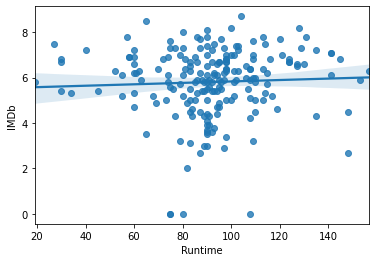

In [14]:
dfSample = df2.sample(200) # shortening the dataset for a cleaner graph
xdataSample, ydataSample = dfSample["Runtime"], dfSample["IMDb"]

sns.regplot(x=xdataSample, y=ydataSample) 
plt.show()

# Correlation between Genre and IMDb rating

In [15]:
df2['Genres'].corr(df2['IMDb'])

0.02843594391429105

In [16]:
model = sm.OLS(df2['IMDb'], df2[['Genres']])
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   IMDb   R-squared (uncentered):                   0.785
Model:                            OLS   Adj. R-squared (uncentered):              0.785
Method:                 Least Squares   F-statistic:                          5.896e+04
Date:                Thu, 21 Jan 2021   Prob (F-statistic):                        0.00
Time:                        01:55:17   Log-Likelihood:                         -39335.
No. Observations:               16112   AIC:                                  7.867e+04
Df Residuals:                   16111   BIC:                                  7.868e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Genres         0.0042   1.73e-05    242.811      0.000       0.004       0.004
==============================================================================
Omnibus:                      187.746   Durbin-Watson:                   1.392
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              194.949
Skew:                          -0.260   Prob(JB):                     4.65e-43
Kurtosis:                       3.145   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

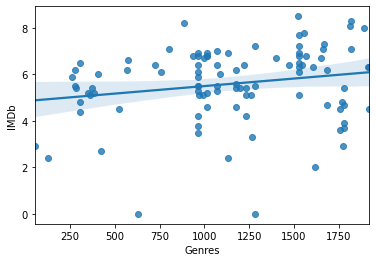

In [17]:
dfSample = df2.sample(100) # shortening the dataset for a cleaner graph
xdataSample, ydataSample = dfSample["Genres"], dfSample["IMDb"]

sns.regplot(x=xdataSample, y=ydataSample) 
plt.show()

# Correlation between Directors and IMDb rating

In [18]:
df2['Directors'].corr(df2['IMDb'])

0.009408658324014151

In [19]:
model = sm.OLS(df2['IMDb'], df2[['Directors']])
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   IMDb   R-squared (uncentered):                   0.708
Model:                            OLS   Adj. R-squared (uncentered):              0.708
Method:                 Least Squares   F-statistic:                          3.909e+04
Date:                Thu, 21 Jan 2021   Prob (F-statistic):                        0.00
Time:                        01:55:18   Log-Likelihood:                         -41811.
No. Observations:               16112   AIC:                                  8.362e+04
Df Residuals:                   16111   BIC:                                  8.363e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Directors      0.0007   3.77e-06    197.716      0.000       0.001       0.001
==============================================================================
Omnibus:                      160.829   Durbin-Watson:                   1.361
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              145.575
Skew:                          -0.189   Prob(JB):                     2.45e-32
Kurtosis:                       2.729   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

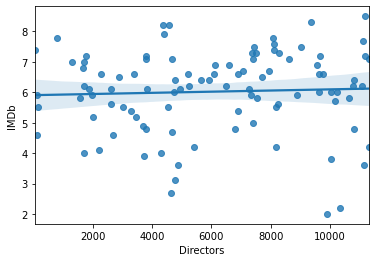

In [20]:
dfSample = df2.sample(100) # shortening the dataset for a cleaner graph
xdataSample, ydataSample = dfSample["Directors"], dfSample["IMDb"]

sns.regplot(x=xdataSample, y=ydataSample) 
plt.show()